# AD Classification Notebook

In this notebook we load the **Group 6 model**, which was fine-tuned on the ADReSS dataset.  
The model weights can be downloaded here: [weights](https://technionmail-my.sharepoint.com/my?id=%2Fpersonal%2Fyarden%5Fnahum%5Fcampus%5Ftechnion%5Fac%5Fil%2FDocuments%2F%D7%A4%D7%A8%D7%95%D7%99%D7%A7%D7%98%20%D7%AA%D7%9B%D7%9F&viewid=80aca3e3%2Dbd79%2D43a9%2D91ca%2D05ae2b1505ec)

After loading the model, we use it to classify the synthetic stories we generated for different personas.  
At the end, a **DataFrame** is displayed, showing for each persona the model’s probability estimates (healthy vs. AD) together with its confidence.  

In [11]:
import json
from pathlib import Path
from typing import List, Dict, Union, Optional
import torch
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoTokenizer, AutoModel
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [12]:
class ADClassifier(nn.Module):
    def __init__(self, model_name: str, dropout=0.1, hidden_dim=None):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        h = self.bert.config.hidden_size
        h2 = hidden_dim or (h // 2)
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(h, h2)
        self.bn = nn.BatchNorm1d(h2)
        self.act = nn.ReLU()
        self.fc2 = nn.Sequential(
            nn.Linear(h2, h2//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2//2, 2)
        )

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = out.pooler_output
        x = self.drop(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.drop(x)
        return self.fc2(x)

In [13]:
# -------- CONFIG --------
MODEL_NAME = "bert-base-uncased"
CKPT_PATH = "best_model_base_bert.pt"
MAX_LEN = 512         # max tokens
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- LOAD MODEL + TOKENIZER --------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = ADClassifier(model_name=MODEL_NAME, dropout=0.1).to(DEVICE)
state = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

ADClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [14]:
@torch.no_grad()
def predict_proba(texts: List[str]) -> torch.Tensor:
    """Return class probabilities [N, 2]: [:,0]=Control, [:,1]=AD."""
    all_probs = []
    for i in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[i:i+BATCH_SIZE]
        enc = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,               # dynamic padding
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        logits = model(enc["input_ids"], enc["attention_mask"])  # [B, 2]
        probs = torch.softmax(logits, dim=-1).cpu()
        all_probs.append(probs)
    return torch.cat(all_probs, dim=0) if all_probs else torch.empty(0, 2)


def compute_predicted_start_age(ages: List[int], prob_ad: List[float], threshold: float = 0.5) -> Optional[int]:
    """
    Optional helper:
    Return the first age where prob_ad >= threshold (default 0.5).
    If never crosses threshold, return None.
    """
    if not ages:
        return None
    # Ensure ages and prob_ad are aligned and sorted by age
    paired = sorted(zip(ages, prob_ad), key=lambda x: x[0])
    for age, p in paired:
        if p >= threshold:
            return age
    return None

In [15]:
def df_from_person_json(person: Dict, add_predicted_start_age: bool = False, threshold: float = 0.5) -> pd.DataFrame:
    """
    Build a DataFrame for a single person JSON with 'start_deterioration_age' column preserved.
    """
    name = person.get("name", "UNKNOWN")
    # <-- keep provided start age
    sda = person.get("start_deterioration_age", None)
    stories = person.get("stories", [])

    texts = [s.get("story", "") for s in stories]
    ages = [s.get("age", None) for s in stories]

    probs = predict_proba(texts)  # [N,2]
    if probs.numel() == 0:
        cols = ["person_name", "start_deterioration_age", "age",
                "story", "prob_control", "prob_ad", "pred_label", "confidence"]
        return pd.DataFrame(columns=cols)

    prob_control = probs[:, 0].numpy()
    prob_ad = probs[:, 1].numpy()
    pred_label = probs.argmax(dim=1).numpy()
    confidence = probs.max(dim=1).values.numpy()

    df = pd.DataFrame({
        "person_name": name,
        "start_deterioration_age": sda,            # <-- column per row
        "age": ages,
        "story": texts,
        "prob_control": prob_control,
        "prob_ad": prob_ad,
        "pred_label": pred_label,                  # 0=Control, 1=AD
        "confidence": confidence
    }).sort_values("age", kind="stable").reset_index(drop=True)

    if add_predicted_start_age:
        predicted = compute_predicted_start_age(
            df["age"].tolist(), df["prob_ad"].tolist(), threshold=threshold)
        # same value for all rows of this person
        df["predicted_start_age"] = predicted
        # store threshold as metadata (optional)
        df.attrs["predicted_start_age_threshold"] = threshold

    return df

In [16]:
def run_on_json_file(json_path: Union[str, Path], add_predicted_start_age: bool = False, threshold: float = 0.5) -> pd.DataFrame:
    with open(json_path, "r", encoding="utf-8") as f:
        person = json.load(f)
    return df_from_person_json(person, add_predicted_start_age=add_predicted_start_age, threshold=threshold)


def run_on_json_dir(json_dir: Union[str, Path], add_predicted_start_age: bool = False, threshold: float = 0.5) -> pd.DataFrame:
    json_dir = Path(json_dir)
    dfs = []
    for p in sorted(json_dir.glob("*.json")):
        try:
            df = run_on_json_file(
                p, add_predicted_start_age=add_predicted_start_age, threshold=threshold)
            df["source_file"] = p.name
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] Failed on {p}: {e}")
    if not dfs:
        cols = ["person_name", "start_deterioration_age", "age", "story",
                "prob_control", "prob_ad", "pred_label", "confidence", "source_file"]
        if add_predicted_start_age:
            cols.append("predicted_start_age")
        return pd.DataFrame(columns=cols)
    return pd.concat(dfs, ignore_index=True)

# Usage

In [ ]:
data_dir = Path("stories/data_oct_6/dementia/")

In [21]:

df_one = run_on_json_file(
    f"{data_dir}/anthony-samuel-reyes.json",
    add_predicted_start_age=True,
    threshold=0.5,
)
df_one

,person_name,start_deterioration_age,age,story,prob_control,prob_ad,pred_label,confidence,predicted_start_age
0,Anthony Samuel Reyes,72,60,It was one of those rides you don't forget—hap...,0.824615,0.175385,0,0.824615,72
1,Anthony Samuel Reyes,72,63,There was this ride I still think about—must'v...,0.544510,0.455490,0,0.544510,72
2,Anthony Samuel Reyes,72,66,"I remember this one ride—early morning, still ...",0.811477,0.188523,0,0.811477,72
3,Anthony Samuel Reyes,72,69,"There was this ride, early in the morning. A g...",0.725120,0.274880,0,0.725120,72
4,Anthony Samuel Reyes,72,72,"That ride... early morning, I think. There was...",0.496375,0.503625,1,0.503625,72
5,Anthony Samuel Reyes,72,75,Morning ride... or was it night? A guy in the ...,0.166793,0.833207,1,0.833207,72


## Prediction on new stories

,person_name,start_deterioration_age,age,story,prob_control,prob_ad,pred_label,confidence,predicted_start_age,source_file
0,Anthony Samuel Reyes,72,60,It was one of those rides you don't forget—hap...,0.824615,0.175385,0,0.824615,72,anthony-samuel-reyes.json
1,Anthony Samuel Reyes,72,63,There was this ride I still think about—must'v...,0.544510,0.455490,0,0.544510,72,anthony-samuel-reyes.json
2,Anthony Samuel Reyes,72,66,"I remember this one ride—early morning, still ...",0.811477,0.188523,0,0.811477,72,anthony-samuel-reyes.json
3,Anthony Samuel Reyes,72,69,"There was this ride, early in the morning. A g...",0.725120,0.274880,0,0.725120,72,anthony-samuel-reyes.json
4,Anthony Samuel Reyes,72,72,"That ride... early morning, I think. There was...",0.496375,0.503625,1,0.503625,72,anthony-samuel-reyes.json
5,Anthony Samuel Reyes,72,75,Morning ride... or was it night? A guy in the ...,0.166793,0.833207,1,0.833207,72,anthony-samuel-reyes.json
6,George Leonard,75,60,"It was late evening, maybe eight or nine o'clo...",0.951141,0.048859,0,0.951141,None,george-leonard.json
7,George Leonard,75,63,I remember this one evening at the clinic—late...,0.918365,0.081635,0,0.918365,None,george-leonard.json
8,George Leonard,75,66,There was this late evening... a knock at the ...,0.946411,0.053589,0,0.946411,None,george-leonard.json
9,George Leonard,75,69,Late one evening... there was a knock. I think...,0.874603,0.125397,0,0.874603,None,george-leonard.json


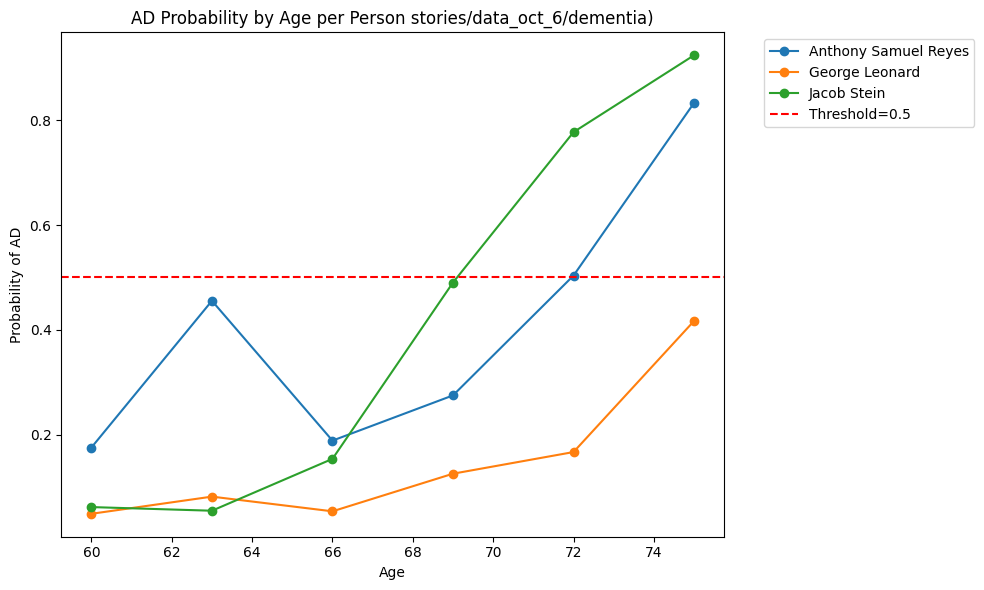

In [18]:
# Path to your folder with persona JSONs (new dementia stories)
# Run predictions over all personas in the folder
df_all = run_on_json_dir(data_dir, add_predicted_start_age=True, threshold=0.5)

# Display the combined DataFrame
display(df_all)

# --- Informative Plot ---
# Plot prob_ad vs. age for each person
plt.figure(figsize=(10, 6))
for person_name, subdf in df_all.groupby("person_name"):
    plt.plot(subdf["age"], subdf["prob_ad"], marker="o", label=person_name)

plt.axhline(0.5, color="red", linestyle="--", label="Threshold=0.5")
plt.xlabel("Age")
plt.ylabel("Probability of AD")
plt.title(f"AD Probability by Age per Person {data_dir})")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()